<a href="https://colab.research.google.com/github/georgezefko/Synthetic-Data-Generation/blob/main/deloite_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2: Inference with pre-trained model
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_inference_with_pre_trained_model.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_inference_with_pre_trained_model.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2 (only Google Colab)

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

## Inference with pre-trained model

In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2
import glob
import os
import numpy as np

We first need to download a image to make predictions on.

## Instance Segmentation

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

In [ ]:
# Create predictor
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:17, 10.2MB/s]                           


In [ ]:
masks_path = '/content/drive/My Drive/Deloite_Orientation1/masks'
whole_cars = '/content/drive/My Drive/Deloite_Orientation1/whole_car_mask'
only_masks = '/content/drive/My Drive/Deloite_Orientation1/only_masks2'
clean_mask = '/content/drive/My Drive/Deloite_Orientation1/clean_mask'
final_set = '/content/drive/MyDrive/Deloite_Orientation1/path_to_final_set/final_set/final'
signle_colors = '/content/drive/MyDrive/Deloite_Orientation1/path_to_final_set/final_set/signle_colors'

#New Data
new_pred_masks = '/content/drive/My Drive/Deloite_Orientation1/nomasks'
whole_cars_new = '/content/drive/My Drive/Deloite_Orientation1/whole_car_mask_new'
whole_cars_new_256 = '/content/drive/MyDrive/Deloite_Orientation1/whole_car_mask_new_256'
clean_mask_new = '/content/drive/My Drive/Deloite_Orientation1/clean_mask_new'
clean_mask_new_256 = '/content/drive/My Drive/Deloite_Orientation1/clean_mask_new_256'
final_set_new = '/content/drive/MyDrive/Deloite_Orientation1/path_to_final_set/final_new'
only_masks_new = '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks'
only_masks_new_256 = '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256'
existing_masks = '/content/drive/MyDrive/Deloite_Orientation1/existing_mask_no_mask'
existing_masks_256 = '/content/drive/MyDrive/Deloite_Orientation1/existing_masks_no_mask256'
thresholded_existing = '/content/drive/MyDrive/Deloite_Orientation1/existing_thresholded'


Below cell is creating the masks for the whole car and saves them in a folder in google drive

In [ ]:
import os
import glob
for file in glob.glob(new_pred_masks + "/*.jpg"):
    im = cv2.imread(file)
    outputs = predictor(im)
    #v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    #v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #plt.imshow(v.get_image()[:, :, ::-1])
    position = outputs['instances'].pred_classes==2
    if len((position==True).nonzero()) !=0:
        car_position = (position == True).nonzero()[0].item()
        car_masks = outputs['instances'].pred_masks[car_position]
        car_masks = car_masks.cpu().numpy()
        #print(str(file))
        ##a is the mask for the car in the image image
        #print(str(file))
        a = car_masks.astype(int)
        a[a > 0 ] = 255
        #Transfor the numpy array to uint8 to match the dtype of the res
        a = a.astype(np.uint8)
        a = cv2.cvtColor(a, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(os.path.join(whole_cars_new , os.path.basename(file)), a)
    else:
      pass    
    


The function below takes an image with the masks and isolates the masks on it.

In [ ]:
def isolate_masks(im2):
  hsv = cv2.cvtColor(im2, cv2.COLOR_BGR2HSV)

  lower_red = np.array([0, 120, 0])
  upper_red = np.array([255, 255, 255])

  mask = cv2.inRange(hsv, lower_red, upper_red)
  res = cv2.bitwise_and(im2,im2, mask= mask)
  return mask, res

Now we have picture 'a' which is the mask, 'im' which is the original image, 'im2' which is the segmented car parts and 'res' which is the semi finished product of isolating only the segmented car parts with nothing else. In order to remove potential background noise, I will try to overlay the mask(a) with the result(res) and obtain the area just around the car.

### Geting a list of all the filenames and creating the clean data set

In [ ]:
#After That we have as many generatd whole masks as cars we generated from

In [ ]:
new_whole_names = []
for file in glob.glob(whole_cars_new + "/*.jpg"):
  new_whole_names.append(os.path.basename(file))
  new_whole_names.sort() 
  
for file in glob.glob(new_pred_masks + "/*.jpg"):
  if os.path.basename(file) in new_whole_names:
    im = cv2.imread(file)
    cv2.imwrite(os.path.join(existing_masks , os.path.basename(file)), im)

In [ ]:
new_whole_names = []
for file in glob.glob(whole_cars_new + "/*.jpg"):
  new_whole_names.append(os.path.basename(file))
  new_whole_names.sort()

In [ ]:
for file in glob.glob(only_masks_new + "/*.jpg"):
  if os.path.basename(file) in new_whole_names:
    im = cv2.imread(file)
    cv2.imwrite(os.path.join(thresholded_existing, os.path.basename(file)), im)

In [ ]:
len(new_whole_names)

1985

In [ ]:
from PIL import Image

In [ ]:
cd drive/MyDrive/Deloite_Orientation1/existing_mask_no_mask/

/content/drive/MyDrive/Deloite_Orientation1/existing_mask_no_mask


In [ ]:
!pip install Pillow

In [ ]:
from PIL import Image
im = cv2.imread('sti_1.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img = Image.fromarray(im, 'RGB')
img = img.resize((256,256))
img = np.asarray(img)
  

# Resize to 256x256

In [ ]:
for file in glob.glob(existing_masks + "/*.jpg"):
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(im, 'RGB')
    img = img.resize((256,256))
    img = np.asarray(img)
    cv2.imwrite(os.path.join(existing_masks_256 , os.path.basename(file)), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  

In [ ]:
for file in glob.glob(whole_cars_new + "/*.jpg"):
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(im, 'RGB')
    img = img.resize((256,256))
    img = np.asarray(img)
    cv2.imwrite(os.path.join(whole_cars_new_256 , os.path.basename(file)), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  

In [ ]:
for file in glob.glob(thresholded_existing + "/*.jpg"):
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(im, 'RGB')
    img = img.resize((256,256))
    img = np.asarray(img)
    cv2.imwrite(os.path.join(only_masks_new_256 , os.path.basename(file)), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  

In [ ]:
i=0
for file in glob.glob(thresholded_existing + "/*.jpg"):
  i+=1
print(i)  

1985


In [ ]:
all_mask_names

['/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/0.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/0_a-aug_4.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/0_a-aug_6.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/0_a-aug_7.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/0_a.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/1.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/10.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/100.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/1001.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/1005.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/1014.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/thresholded_masks_256/1015.jpg',
 '/content/drive/MyDrive/Deloite_Orientation1/t

In [ ]:
#Appending all file names

file_names = []
for file in glob.glob(existing_masks_256 + "/*.jpg"):
  file_names.append(os.path.basename(file))
  file_names.sort() 

#Appedning the whole car mask image
all_car_names = [img for img in glob.glob(whole_cars_new_256 + "/*.jpg")]
all_car_names.sort() # ADD THIS LINE
all_cars = []
for img in all_car_names:
    n= cv2.imread(img)
    all_cars.append(n) 


#Appending the whole masks images 
all_mask_names = [img for img in glob.glob(only_masks_new_256 + "/*.jpg")]
all_mask_names.sort() # ADD THIS LINE
all_masks = []
for img in all_mask_names:
    n= cv2.imread(img)
    all_masks.append(n)   

#Overlaying masks and car parts to remove background noise
for i in range(len(all_masks)):
    all_cars[i][all_cars[i]>150]=255
    all_cars[i][all_cars[i]<=150]=0
    
    #Preprocessing both of the images at th same time generate new images and save them at clean mask folder
    flat_a = all_cars[i].flatten()
    flat_res = all_masks[i].flatten()

    #Wherever I see 0 in a image, I want to put 0 in the corresponinf position in the res image

    mask = (flat_a == 0)
    new_array = np.copy(flat_a)
    flat_res[mask] = new_array[mask] 
    res = flat_res.reshape(256,256,3)
    cv2.imwrite(os.path.join(clean_mask_new_256, os.path.basename(file_names[i])), res)


### Overlay of pictures

In [ ]:
import glob
import os
import cv2
#we need to imprt the whole car mask and the clean mask
file_names = []
for file in glob.glob(whole_cars_new_256+ "/*.jpg"):
  file_names.append(os.path.basename(file))
  file_names.sort() 

#Appedning the whole car mask image
all_car_names = [img for img in glob.glob(whole_cars_new_256 + "/*.jpg")]
all_car_names.sort() # ADD THIS LINE
all_cars = []
for img in all_car_names:
    n= cv2.imread(img)
    all_cars.append(n) 

#Appending the clean masks images 
clean_mask_names = [img for img in glob.glob(clean_mask_new_256 + "/*.jpg")]
clean_mask_names.sort() # ADD THIS LINE
clean_masks2 = []
for img in clean_mask_names:
    n= cv2.imread(img)
    clean_masks2.append(n)  

for i in range(len(clean_masks2)):    
    #converting clean image to gray scale to isolat the non black pixels
    gray = cv2.cvtColor(clean_masks2[i], cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
    #Converting back to 3 channels which keeps values on 0,255
    blackAndWhiteImage = cv2.cvtColor(blackAndWhiteImage, cv2.COLOR_GRAY2BGR)
    #non_black_pixels_mask = np.any(blackAndWhiteImage!= [0, 0, 0], axis=-1) 
    bw_flat = blackAndWhiteImage.flatten()
    cl_flat = clean_masks2[i].flatten()
    wc = all_cars[i].flatten()   
    for j in range(len(bw_flat)):
        if bw_flat[j] >0:
           wc[j]=cl_flat[j]   
    wc = wc.reshape(256,256,3)       
    cv2.imwrite(os.path.join(final_set_new, os.path.basename(file_names[i])), wc)

In [ ]:
#Now we want to save every photo has an exact number of colors

In [ ]:
def isolate_colors(picture):
    width, height = picture.size
    for x in range(width):
        for y in range(height):
            current_color = picture.getpixel((x,y))
            if (current_color[0]>=0 and current_color[0]<10) and (current_color[1]>=0 and current_color[1]<10) and (current_color[2]>=0 and current_color[2]<10):
                picture.putpixel((x, y), (0, 0, 0)) #white

            elif current_color[0]>240  and current_color[1]>=240 and current_color[2]>=240:    
                picture.putpixel((x, y), (255, 255, 255)) #black

            elif current_color[0]<180  and current_color[1]>=120 and current_color[2]>=120:    
                picture.putpixel((x, y), (0, 255, 255))#light blue

            elif  (current_color[0]>=0 and current_color[0]<90)  and (current_color[0]>=0 and current_color[1]<100) and current_color[2]>=140:   
                picture.putpixel((x, y), (0, 0, 255))  #ldark blue

            elif current_color[0]>150  and (current_color[1]>100 and current_color[1]<180)  and current_color[2]<100:    
                picture.putpixel((x, y), (255, 144, 0))  #orange

            elif current_color[0]>110  and (current_color[1]<120)  and current_color[2]>120:    
                picture.putpixel((x, y), (255, 0, 255))  #pink  

            elif current_color[0]<40  and (current_color[1]>70 and current_color[1]<200)  and current_color[2]<50:    
                picture.putpixel((x, y), (0, 100, 0))  #green  

            elif (current_color[0]>20 and current_color[0]<150)  and (current_color[1]>20 and current_color[1]<90)  and (current_color[2]>5 and current_color[2]<50):        
                picture.putpixel((x, y), (125, 30, 0))  #brown

            elif current_color[0]>210   and current_color[1]>210  and current_color[2]<120:    
                picture.putpixel((x, y), (255, 255, 0))  #yellow   
            else:
                picture.putpixel((x, y), (0, 0, 0))  # 
    return picture  

In [ ]:
from PIL import Image
import cv2
import numpy as np
import os

In [ ]:
cd drive/MyDrive/Deloite_Orientation1/path_to_final_set/final_set/final/

/content/drive/MyDrive/Deloite_Orientation1/path_to_final_set/final_set/final


In [ ]:
for file in glob.glob(final_set + "/*.jpg"):
  im = cv2.imread(file)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
  img = Image.fromarray(im, 'RGB')
  img = isolate_colors(img)
  cv_image = np.array(img) 
  cv2.imwrite(os.path.join(signle_colors , os.path.basename(file)), cv2.cvtColor(cv_image, cv2.COLOR_RGB2BGR))

In [ ]:
cd ../clean_mask

/content/drive/My Drive/Deloite_Orientation1/clean_mask


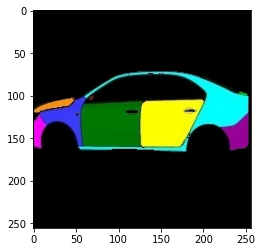

In [ ]:
clean1 = cv2.imread('970.jpg')
clean1 = cv2.cvtColor(clean1, cv2.COLOR_BGR2RGB)
plt.imshow(clean1)

In [ ]:
#converting an image to gray scale
gray = cv2.cvtColor(clean1, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)
#Converting back to 3 channels which keeps values on 0,255
blackAndWhiteImage = cv2.cvtColor(blackAndWhiteImage, cv2.COLOR_GRAY2BGR)
non_black_pixels_mask = np.any(blackAndWhiteImage!= [0, 0, 0], axis=-1) 

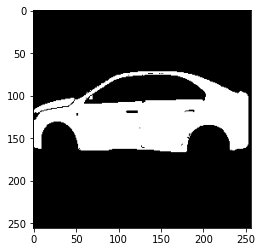

In [ ]:
plt.imshow(blackAndWhiteImage)

In [ ]:
bw_flat = blackAndWhiteImage.flatten()
cl_flat = clean1.flatten()
wc = wh1.flatten()

In [ ]:
m = (bw_flat>0)
new_array = np.copy(bw_flat)
wc[m] = cl_flat[m] 
r = cl_flat.reshape(256,256,3)

In [ ]:
for i in range(len(bw_flat)):
  if bw_flat[i] >0:
    wc[i]=cl_flat[i]



In [ ]:
m = (bw_flat>0)

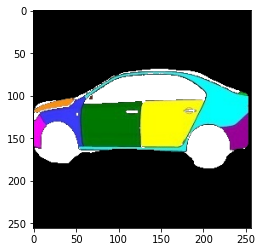

In [ ]:
wc = wc.reshape(256,256,3)
plt.imshow(wc)

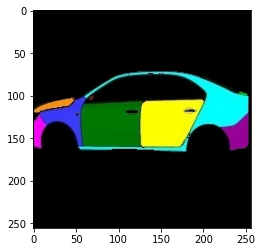

In [ ]:
plt.imshow(clean1)

In [ ]:
bw_flat>0

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

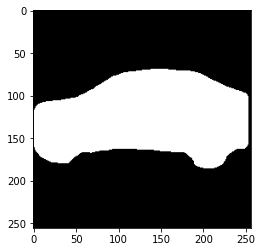

In [ ]:
plt.imshow(wh1)

In [ ]:
fmask = (non_black_pixels_mask==True)

In [ ]:
fmask.shape

(256, 256)

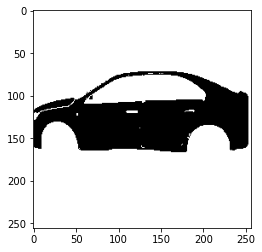

In [ ]:
image_copy = blackAndWhiteImage.copy()

black_pixels_mask = np.all(blackAndWhiteImage == [0, 0, 0], axis=-1)

non_black_pixels_mask = np.any(blackAndWhiteImage!= [0, 0, 0], axis=-1)  
# or non_black_pixels_mask = ~black_pixels_mask

image_copy[black_pixels_mask] = [255, 255, 255]
image_copy[non_black_pixels_mask] = [0, 0, 0]

plt.imshow(image_copy)
plt.show()


In [ ]:
non_black_pixels_mask

True

In [ ]:
cd ../whole_car_mask

/content/drive/My Drive/Deloite_Orientation1/whole_car_mask


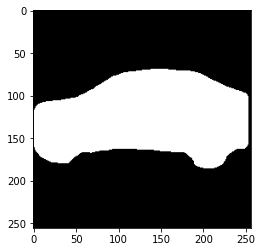

In [ ]:

wh1 = cv2.imread('970.jpg')
wh1 = cv2.cvtColor(wh1, cv2.COLOR_BGR2RGB)
wh1[wh1>150]=255
wh1[wh1<=150]=0
plt.imshow(wh1)

In [ ]:
non_black_pixels_mask2 = np.any(clean1 != [0, 0, 0], axis=-1)

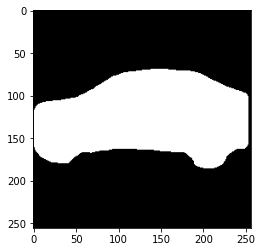

In [ ]:
plt.imshow(wh1)

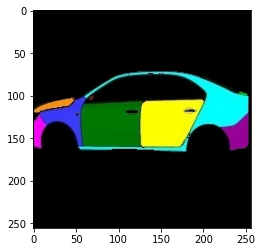

In [ ]:
plt.imshow(clean1)

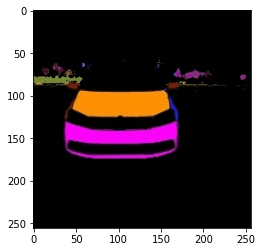

In [ ]:
im2 = cv2.imread(only_masks + "/0.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imshow(im2)

In [ ]:
im.shape

(256, 256, 3)

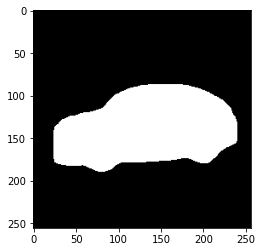

In [ ]:
im[im>150]=255
im[im<=150]=0
plt.imshow(im)

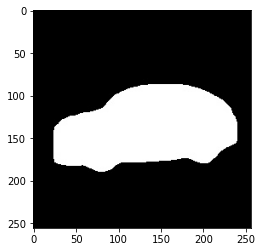

In [ ]:
im = cv2.imread(whole_cars + "/0_a.jpg")
#im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [ ]:
flat_a = im.flatten()
flat_res = im2.flatten()

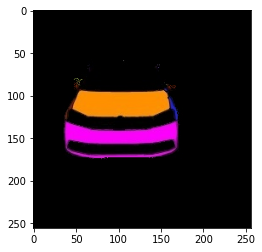

In [ ]:
mask = (flat_a == 0)
new_array = np.copy(flat_a)
flat_res[mask] = new_array[mask] 
res = flat_res.reshape(256,256,3)
plt.imshow(res)

In [ ]:
#Replace the 1 in the numpy array with 3
a[a > 0 ] = 255
#Transfor the numpy array to uint8 to match the dtype of the res
a = a.astype(np.uint8)
#add a color channel to the array to match the dimensions of res
a = cv2.cvtColor(a, cv2.COLOR_GRAY2BGR)

##Flattening th images to engage element wise comparison
flat_a = a.flatten()
flat_res = res.flatten()

#Wherever I see 0 in a image, I want to put 0 in the corresponinf position in the res image

mask = (flat_a == 0)
new_array = np.copy(flat_a)
flat_res[mask] = new_array[mask] 
res = flat_res.reshape(256,256,3)
plt.imshow(res)